## 1. 데이터 준비

In [1]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy
import pickle

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_not_contain_every_class, split_contain_every_class, generate_server_idcs, CustomSubset, split_noniid
from torchvision.models import resnet50

torch.manual_seed(42)
np.random.seed(42)

In [2]:
COMMUNICATION_ROUNDS = 50
EPS_1 = 0.4
EPS_2 = 1.6
N_CLIENTS = 10

total_client_data = 1000
data_per_class = 50
ALPHA = 0.1

In [3]:
data = datasets.MNIST(root="MNIST/", download=False)

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

idcs = np.random.permutation(len(data))

#print(len(data))

In [4]:
def do_epoch_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA=ALPHA):
    train_idcs, test_idcs = idcs[:int(total_client_data*10)], idcs[int(total_client_data*10):]
    train_labels = data.targets
    test_labels = data.targets[int(total_client_data*10):]


    client_idcs = split_noniid(train_idcs, train_labels, alpha=ALPHA, n_clients=N_CLIENTS)
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9),test_data)
    
    distillation_data_file = f'distill_data/MNIST/{data_per_class*10}.pth'
    if not os.path.exists(distillation_data_file):
        torch.save(server.make_distillation_data(data_per_class=data_per_class), distillation_data_file)
        
    distillation_data = torch.load(distillation_data_file)

    clients = [Client(ConvNet, lambda x: torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, i, distillation_data) 
               for i, dat in enumerate(client_data)]

    client_accs = []
    global_accs = []
    client_logits = []

    for c_round in range(COMMUNICATION_ROUNDS):

        for client in clients:
            if c_round == COMMUNICATION_ROUNDS -1:
                #client.synchronize_with_server(server)
                client.distill((distill_data[0], distill_data[1], averaged_logits))

            if c_round != 0:
                client.compute_weight_update(epochs=1)

        if c_round % 10 == 0 or c_round == COMMUNICATION_ROUNDS -1:
            acc_clients = [client.evaluate() for client in clients]
            client_acc = round(sum(acc_clients) / len(acc_clients), 3)
            client_accs.append(client_acc)

            accuracies = [server.evaluate_distil(client.model) for client in clients]
            global_acc = round(np.mean(accuracies), 3)
            global_accs.append(global_acc)
            
        if c_round == COMMUNICATION_ROUNDS -2:
            for i, client in enumerate(clients):
                if i == 0:
                    distill_data = server.get_clients_logit(client.model,data_per_class=data_per_class)
                    client_logits.append(distill_data[2])
                else:
                    client_logits.append(server.get_clients_logit(client.model,data_per_class=data_per_class)[2])
            averaged_logits = server.make_averaged_logits(client_logits)
    
    print(f'total_client_data: {total_client_data}, data_per_class: {data_per_class}')
    print(f'first acc: {client_accs[0]}, {global_accs[0]}')
    print(f'acc before distill: {client_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {global_accs[-1]}')
    return client_accs, global_accs

In [5]:
def do_epoch_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA=ALPHA):
    train_idcs, test_idcs = idcs[:int(total_client_data*10)], idcs[int(total_client_data*10):]
    train_labels = data.targets
    test_labels = data.targets[int(total_client_data*10):]


    client_idcs = split_noniid(train_idcs, train_labels, alpha=ALPHA, n_clients=N_CLIENTS)
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9),test_data)
    
    distillation_data_file = f'distill_data/MNIST/{data_per_class*10}.pth'
    if not os.path.exists(distillation_data_file):
        torch.save(server.make_distillation_data(data_per_class=data_per_class), distillation_data_file)
        
    distillation_data = torch.load(distillation_data_file)

    clients = [Client(ConvNet, lambda x: torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, i, distillation_data) 
               for i, dat in enumerate(client_data)]

    client_accs = []
    global_accs = []
    client_logits = []

    for c_round in range(COMMUNICATION_ROUNDS):

        for client in clients:
            if c_round == COMMUNICATION_ROUNDS -1:
                #client.synchronize_with_server(server)
                client.distill((distill_data[0], distill_data[1], averaged_logits))

            if c_round != 0:
                client.compute_weight_update(epochs=1)

        if c_round % 10 == 0 or c_round == COMMUNICATION_ROUNDS -1:
            acc_clients = [client.evaluate() for client in clients]
            client_acc = round(sum(acc_clients) / len(acc_clients), 3)
            client_accs.append(client_acc)

            accuracies = [server.evaluate_distil(client.model) for client in clients]
            global_acc = round(np.mean(accuracies), 3)
            global_accs.append(global_acc)
            
        if c_round == COMMUNICATION_ROUNDS -2:
            for i, client in enumerate(clients):
                if i == 0:
                    distill_data = server.get_clients_logit(client.model,data_per_class=data_per_class)
                    client_logits.append(distill_data[2])
                else:
                    client_logits.append(server.get_clients_logit(client.model,data_per_class=data_per_class)[2])
            averaged_logits = server.make_averaged_logits(client_logits)
    
    print(f'total_client_data: {total_client_data}, data_per_class: {data_per_class}')
    print(f'first acc: {client_accs[0]}, {global_accs[0]}')
    print(f'acc before distill: {client_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {global_accs[-1]}')
    return client_accs, global_accs

In [6]:
import pandas as pd
import numpy as np

# Create a multi-index for the columns
columns = pd.MultiIndex.from_product([['client_accs', 'global_accs'], ['before_distill', 'after_distill']],
                                     names=['acc_type', 'distill_state'])

client_data_values = [50, 100, 200, 500]
distill_data_values = [200, 500, 1000]

index = pd.MultiIndex.from_product([client_data_values, distill_data_values], names=['client_data', 'distill_data'])

# Initialize an empty DataFrame with the desired MultiIndex for rows and columns
df = pd.DataFrame(np.nan, index=index, columns=columns)

for i, client_data in enumerate(client_data_values):
    for j, distill_data in enumerate(distill_data_values):
        client_accs, global_accs = do_epoch_experiments(total_client_data=client_data*10, data_per_class=int(distill_data//10), ALPHA=0.1)

        # Set the values in the DataFrame
        df.loc[(client_data, distill_data), ('client_accs', 'before_distill')] = client_accs[-2]
        df.loc[(client_data, distill_data), ('client_accs', 'after_distill')] = client_accs[-1]
        df.loc[(client_data, distill_data), ('global_accs', 'before_distill')] = global_accs[-2]
        df.loc[(client_data, distill_data), ('global_accs', 'after_distill')] = global_accs[-1]

df.to_csv('results/global_distill/1320.csv')


total_client_data: 500, data_per_class: 20
first acc: 0.107, 0.094
acc before distill: 0.873, 0.242
last acc: 0.647, 0.173
total_client_data: 500, data_per_class: 50
first acc: 0.04, 0.106
acc before distill: 0.8, 0.299
last acc: 0.813, 0.412
total_client_data: 500, data_per_class: 100
first acc: 0.12, 0.106
acc before distill: 0.867, 0.267
last acc: 0.833, 0.496
total_client_data: 1000, data_per_class: 20
first acc: 0.227, 0.095
acc before distill: 0.883, 0.304
last acc: 0.767, 0.431
total_client_data: 1000, data_per_class: 50
first acc: 0.127, 0.092
acc before distill: 0.913, 0.335
last acc: 0.667, 0.44
total_client_data: 1000, data_per_class: 100
first acc: 0.033, 0.109
acc before distill: 0.957, 0.31
last acc: 0.803, 0.443
total_client_data: 2000, data_per_class: 20
first acc: 0.092, 0.104
acc before distill: 0.935, 0.338
last acc: 0.732, 0.239
total_client_data: 2000, data_per_class: 50
first acc: 0.025, 0.098
acc before distill: 0.818, 0.274
last acc: 0.723, 0.279
total_client_da

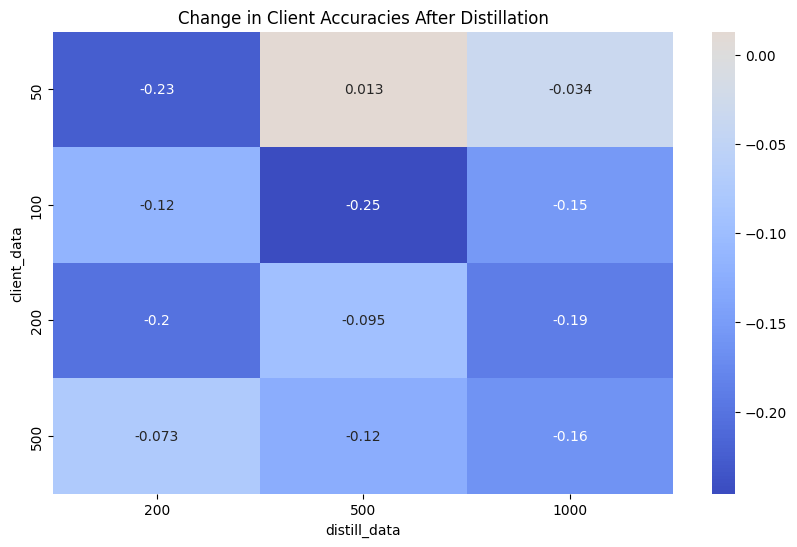

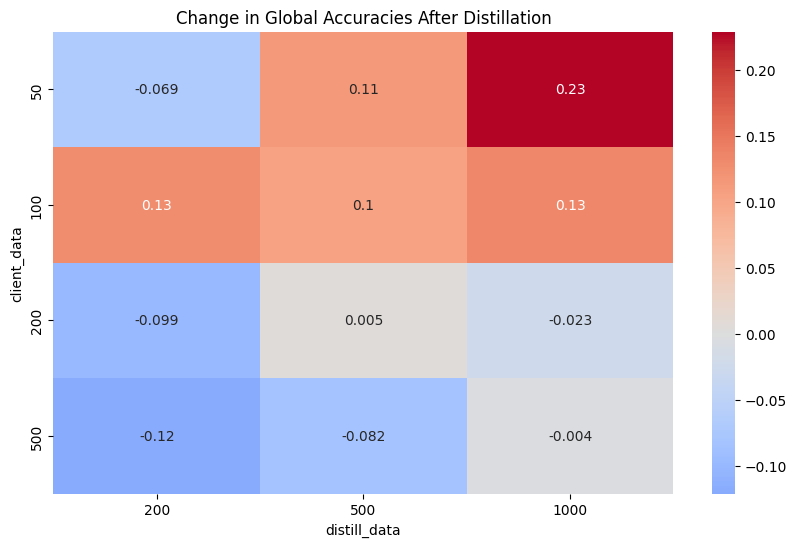

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the DataFrame
df = pd.read_csv('results/global_distill/1320.csv', header=[0, 1], index_col=[0, 1])

# Compute the changes in accuracies after distillation
df[('client_accs', 'change')] = df[('client_accs', 'after_distill')] - df[('client_accs', 'before_distill')]
df[('global_accs', 'change')] = df[('global_accs', 'after_distill')] - df[('global_accs', 'before_distill')]

# Create heatmaps
plt.figure(figsize=(10, 6))
sns.heatmap(df[('client_accs', 'change')].unstack(), annot=True, cmap='coolwarm', center=0)
plt.title('Change in Client Accuracies After Distillation')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df[('global_accs', 'change')].unstack(), annot=True, cmap='coolwarm', center=0)
plt.title('Change in Global Accuracies After Distillation')
plt.show()


In [7]:
#client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final = do_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA)

In [8]:
import os
import pickle
import pprint

# Define the directory where the results are saved
save_dir = 'results/data_amount'

# Define the different data_per_class values
data_per_class_values = [10, 20, 50, 100, 200, 500]

# For pretty printing
pp = pprint.PrettyPrinter(indent=4)


#0323: client 10, 50 결과 저장
with open(os.path.join(save_dir, f'0417_ALPHA_0.1.pkl'), 'rb') as f:
    results = pickle.load(f)

pp.pprint(results)


FileNotFoundError: [Errno 2] No such file or directory: 'results/data_amount/0417_ALPHA_0.1.pkl'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the different data_per_class values
total_client_data_values = [50, 100, 200, 500, 1000, 2000, 5000]
data_per_class_values = [10, 20, 50, 100, 200, 500]

# Metrics
metrics = ['global_acc_after_distill', 'global_acc_final']

# Prepare list to store the rows
data = []

# Fill in the rows
for data_per_class in data_per_class_values:
    with open(os.path.join(save_dir, f'0412_ALPHA_0.1.pkl'), 'rb') as f:
        results = pickle.load(f)

    for total_client_data in total_client_data_values:
        for metric in metrics:
            row = {"total_client_data": total_client_data, "metric": metric, "data_per_class": data_per_class, "value": round(results[(total_client_data, data_per_class, 0.1)][metric], 2)}
            data.append(row)

# Create the DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame to the desired shape
df = df.pivot(index=['total_client_data', 'metric'], columns='data_per_class', values='value')

# Filter for 'client_acc_after_distill'
df_after_distill = df.xs('global_acc_after_distill', level='metric')
df_final = df.xs('global_acc_final', level='metric')

# Plot heatmap
fig, axs = plt.subplots(1, 2, figsize=(20,8))  # Create a figure and a set of subplots
fig.suptitle('Heatmaps for client_acc_after_distill and client_acc_final')

sns.heatmap(df_after_distill, annot=True, cmap="YlGnBu", ax=axs[0])
axs[0].set_title('global_acc_after_distill Heatmap')

sns.heatmap(df_final, annot=True, cmap="YlGnBu", ax=axs[1])
axs[1].set_title('global_acc_final Heatmap')

plt.show()


### 3) 서버, client data 양 2차 실험

## 2.Clustering 실험

In [ ]:
def do_clustering_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA=ALPHA):
    train_idcs, test_idcs = idcs[:int(total_client_data*10)], idcs[int(total_client_data*10):]
    train_labels = data.train_labels.numpy()
    test_labels = data.train_labels.numpy()[int(total_client_data*10):]

    client_idcs = split_noniid(train_idcs, train_labels, alpha=ALPHA, n_clients=N_CLIENTS)#, data_per_class=int(total_client_data/10))
    # server_idcs = generate_server_idcs(test_idcs, test_labels, int(total_client_data*10))

    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9),test_data)

    
    distillation_data_file = f'distillation_data_{data_per_class}_per_class.pth'

    # Check if the file already exists
    if not os.path.exists(distillation_data_file):
        # The file does not exist, generate and save the distillation data
        distillation_data = server.make_distillation_data(data_per_class=data_per_class)
        torch.save(distillation_data, distillation_data_file)

    # Load the distillation data
    distillation_data = torch.load(distillation_data_file)

    clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, i, distillation_data) 
               for i, dat in enumerate(client_data)]

    def aggregate(cluster_indices_new):
        cluster_indices = cluster_indices_new
        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

        server.aggregate_clusterwise(client_clusters)

        return cluster_indices

    cfl_stats = ExperimentLogger()

    cluster_indices = [np.arange(len(clients)).astype("int")]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


    for c_round in range(1, COMMUNICATION_ROUNDS+1):

        if c_round == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            if c_round == 1:
                client.distill()

            train_stats = client.compute_weight_update(epochs=1) #train client

            if c_round == 1000:
                client.reset()

        cluster_indices_new = []

        for idc in cluster_indices:
            max_norm = server.compute_max_update_norm([clients[i] for i in idc])
            mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])

            #cluster 나누는 기준
            if c_round == COMMUNICATION_ROUNDS: #무조건 한번 나누기
                similarities = server.compute_pairwise_similarities(clients)

                server.cache_model(idc, clients[idc[0]].W, acc_clients)

                c1, c2, c3 = server.cluster_clients_GMM(similarities[idc][:,idc])
                cluster_indices_new += [c1, c2, c3]

        if c_round == 1000:
            cluster_indices = aggregate(cluster_indices_new)

        acc_clients = [client.evaluate() for client in clients]

        if c_round == COMMUNICATION_ROUNDS: #무조건 한번 나누기
            label_accuracies = pd.DataFrame()
            label_predicted = pd.DataFrame()
            label_soft_sum = pd.DataFrame()
            label_diff = pd.DataFrame()

            for i, client in enumerate(clients):
                acc, pred, sum_, diff = server.evaluate(client.model)
                # Convert each dictionary to a DataFrame and append to the respective DataFrame
                label_accuracies = label_accuracies.append(pd.DataFrame(acc, index=[i]))
                label_predicted = label_predicted.append(pd.DataFrame(pred, index=[i]))
                label_soft_sum = label_soft_sum.append(pd.DataFrame(sum_, index=[i]))
                label_diff = label_diff.append(pd.DataFrame(diff, index=[i]))

            # Reset index for all DataFrames
            label_accuracies.reset_index(drop=True, inplace=True)
            label_predicted.reset_index(drop=True, inplace=True)
            label_soft_sum.reset_index(drop=True, inplace=True)
            label_diff.reset_index(drop=True, inplace=True)

        if c_round == 1:
            first_accuracies = pd.DataFrame()
            for i, client in enumerate(clients):
                first_acc, pred, sum_, diff = server.evaluate(client.model)
                first_accuracies = pd.concat([first_accuracies, pd.DataFrame(first_acc, index=[i])])
            first_accuracies = first_accuracies.fillna(0)

            client_acc_after_distill = sum(acc_clients)/len(acc_clients)
            global_acc_after_distill = np.mean(np.ravel(first_accuracies.values))


        elif c_round == COMMUNICATION_ROUNDS:
            client_acc_final = sum(acc_clients)/len(acc_clients)
            global_acc_final = np.mean(np.ravel(label_accuracies.values))

        average_dw = server.get_average_dw(clients)
        #print(average_dw)
        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                      "rounds" : c_round, "clusters" : cluster_indices, "average_dw": average_dw})


        display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)


    for idc in cluster_indices:    
        server.cache_model(idc, clients[idc[0]].W, acc_clients)
    
    client_acc_after_distill = round(client_acc_after_distill, 3)
    global_acc_after_distill = round(global_acc_after_distill, 3)
    client_acc_final = round(client_acc_final, 3)
    global_acc_final = round(global_acc_final, 3)
    
    return client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final

    print(client_acc_after_distill, global_acc_after_distill)
    print(client_acc_final, global_acc_final)

In [ ]:
first_accuracies

In [ ]:
label_accuracies.sort_index(axis=1)

In [ ]:
label_soft_sum.sort_index(axis=1)

In [ ]:
label_diff.sort_index(axis=1)

In [ ]:
label_predicted.sort_index(axis=1)

In [ ]:
from sklearn.decomposition import PCA
# Instantiate PCA
pca = PCA(n_components=2)

# Apply PCA to the dataframes
label_accuracies_pca = pca.fit_transform(label_accuracies)
label_predicted_pca = pca.fit_transform(label_predicted)
label_soft_sum_pca = pca.fit_transform(label_soft_sum)
label_diff_pca = pca.fit_transform(label_diff)
transformed_data = pca.fit_transform(similarities)

# Create labels
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plots with larger dots
dot_size = 50
axs[0, 0].scatter(label_accuracies_pca[:, 0], label_accuracies_pca[:, 1], c=labels, s=dot_size)
axs[0, 0].set_title('Label Accuracies')
axs[0, 1].scatter(label_predicted_pca[:, 0], label_predicted_pca[:, 1], c=labels, s=dot_size)
axs[0, 1].set_title('Label Predicted')
axs[1, 0].scatter(label_soft_sum_pca[:, 0], label_soft_sum_pca[:, 1], c=labels, s=dot_size)
axs[1, 0].set_title('Label Soft Sum')
axs[1, 1].scatter(label_diff_pca[:, 0], label_diff_pca[:, 1], c=labels, s=dot_size)
axs[1, 1].set_title('Label Soft Diff')

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores
silhouette_accuracies = silhouette_score(label_accuracies_pca, labels)
silhouette_predicted = silhouette_score(label_predicted_pca, labels)
silhouette_soft_sum = silhouette_score(label_soft_sum_pca, labels)
silhouette_diff = silhouette_score(label_diff_pca, labels)
silhouette_transformed_data = silhouette_score(transformed_data, labels)

print('Silhouette Score for Accuracies:', silhouette_accuracies)
print('Silhouette Score for Predicted:', silhouette_predicted)
print('Silhouette Score for Soft Sum:', silhouette_soft_sum)
print('Silhouette Score for diff:', silhouette_diff)
print('Silhouette Score for Model params:', silhouette_transformed_data)



In [ ]:
#df.sort_index(axis=1)

데이터 Cluster 별 모델 파라미터 분포

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit and transform your data to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(similarities)

# Assign labels based on index ranges
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 0.35, len(unique_labels)))

# Plot the transformed data with labels
for label, color in zip(unique_labels, colors):
    idx = np.where(labels == label)
    plt.scatter(transformed_data[idx, 0], transformed_data[idx, 1], color=color, label=f'Cluster {label}')

# Add a legend
plt.legend()

plt.show()
